In this notebook I am gonna do Explicit Collaborative Filtering using ratings data so as to recommend movies to the user based on his previous likings in the past and also based on similar user rating that movie.After the end of this notebook,you will
1. recommend movies based on movie-movie interaction and finding the similar movies to a movie.\
2.predicting movies that user did not rate and finding top k to recommend


In [1]:
#Installing required libraries
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import TruncatedSVD
from sklearn.neighbors import NearestNeighbors

In [2]:
ratings = pd.read_csv('rating.csv')
ratings

,userId,movieId,rating,timestamp
0,1,2,3.5,2005-04-02 23:53:47
1,1,29,3.5,2005-04-02 23:31:16
2,1,32,3.5,2005-04-02 23:33:39
3,1,47,3.5,2005-04-02 23:32:07
4,1,50,3.5,2005-04-02 23:29:40
...,...,...,...,...
20000258,138493,68954,4.5,2009-11-13 15:42:00
20000259,138493,69526,4.5,2009-12-03 18:31:48
20000260,138493,69644,3.0,2009-12-07 18:10:57
20000261,138493,70286,5.0,2009-11-13 15:42:24


In [3]:
movies = pd.read_csv('movie.csv')
movies

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
27273,131254,Kein Bund für's Leben (2007),Comedy
27274,131256,"Feuer, Eis & Dosenbier (2002)",Comedy
27275,131258,The Pirates (2014),Adventure
27276,131260,Rentun Ruusu (2001),(no genres listed)


To make the memory manageable we will use only 45 percentage of entire 20 million dataset. So, lets randomly select some users

In [4]:
rand_userIds = np.random.choice(ratings['userId'].unique(), 
                                size=int(len(ratings['userId'].unique())*0.45), 
                                replace=False)

ratings = ratings.loc[ratings['userId'].isin(rand_userIds)]

print('There are {} rows of data from {} users'.format(len(ratings), len(rand_userIds)))

There are 9019314 rows of data from 62321 users


In [5]:
train = ratings[['userId', 'movieId', 'rating']]

In [6]:
print('we have',train.shape[0], 'ratings')
print('the number of unique users we have is:', len(train.userId.unique()))
print('the number of unique movies we have is:', len(train.movieId.unique()))
print("The median user rated %d movies."%train.userId.value_counts().median())
print('The max rating is: %d'%train.rating.max(),"the min rating is: %d"%train.rating.min())

we have 9019314 ratings
the number of unique users we have is: 62321
the number of unique movies we have is: 23368
The median user rated 68 movies.
The max rating is: 5 the min rating is: 0


Exploratory Data Analysis

Lets find the distribution of movie ratings

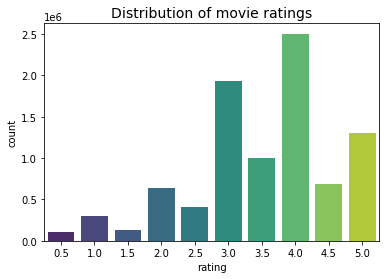

In [7]:
sns.countplot(x="rating", data=ratings, palette="viridis")
plt.title("Distribution of movie ratings", fontsize=14)
plt.show()

In [8]:
def create_X(df):
    """
    Generates a sparse matrix from ratings dataframe.

    Args:
        df: pandas dataframe containing 3 columns (userId, movieId, rating)

    Returns:
        X: sparse matrix
        user_mapper: dict that maps user id's to user indices
        user_inv_mapper: dict that maps user indices to user id's
        movie_mapper: dict that maps movie id's to movie indices
        movie_inv_mapper: dict that maps movie indices to movie id's
        
      We need these dictionaries because they map which row/column of the utility matrix corresponds to which user/movie id.

    Our X (user-item) matrix is a scipy.sparse.csr_matrix which stores the data sparsely.
    """
    M = df['userId'].nunique()
    N = df['movieId'].nunique()

    user_mapper = dict(zip(np.unique(df["userId"]), list(range(M))))
    movie_mapper = dict(zip(np.unique(df["movieId"]), list(range(N))))

    user_inv_mapper = dict(zip(list(range(M)), np.unique(df["userId"])))
    movie_inv_mapper = dict(zip(list(range(N)), np.unique(df["movieId"])))

    user_index = [user_mapper[i] for i in df['userId']]
    item_index = [movie_mapper[i] for i in df['movieId']]

    X = csr_matrix((df["rating"], (user_index,item_index)), shape=(M,N))

    return X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper

X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper = create_X(train)

In [9]:
n_total = X.shape[0]*X.shape[1]
n_ratings = X.nnz
sparsity = n_ratings/n_total
print(f"Matrix sparsity: {round(sparsity*100,2)}%")

Matrix sparsity: 0.62%


In [10]:
print(np.shape(X))

(62321, 23368)


In [11]:
train = train.merge(movies)

In [12]:
# initial hyperparameter
epsilon = 1e-9
n_latent_factors = 30

# generate item latent features
item_svd = TruncatedSVD(n_components = n_latent_factors)
item_features = item_svd.fit_transform(X.transpose()) + epsilon
print(np.shape(item_features))

# generate user latent features
user_svd = TruncatedSVD(n_components = n_latent_factors)
user_features = user_svd.fit_transform(X) + epsilon

(23368, 30)


TRUNCATED SINGULAR VALUE DECOMPOSITION

There can be some generalities in our data more concise and descriptive rather than 60k rows. For instance, any given movie can, to a rough degree of approximation, be described in terms of some basic attributes such as overall quality, whether it's an action movie or a comedy, what stars are in it, and so on. And every user's preferences can likewise be roughly described in terms of whether they tend to rate high or low, whether they prefer action movies or comedies, what stars they like, and so on. And if those basic assumptions are true, then a lot of the 60 thousand ratings ought to be explainable by a lot less than 60 k  numbers, since, for instance, a single number specifying how much action a particular movie has may help explain why a few million action-buffs like that movie.

So,now the problem arises how to get those attributes(latent factors) to our utility matrix(user-movie ratings matrix). We can get this by utilising the mathematical concept of Truncated Singular Value Decomposition(SVD) and decompose it to smaller components.
SVD works by decomposing a matrix into three matrices. 

A = U.S.V.T

Matrix U: singular matrix of (user*latent factors)

Matrix S: diagonal matrix (shows the strength of each latent factor)

Matrix V: singular matrix of (item*latent factors)

In [13]:
def find_similar_movies(movie_id, X, movie_mapper, movie_inv_mapper, k, metric='cosine'):
    """
    Finds k-nearest neighbours for a given movie id.(used to predict similar movies to a movie)

    Args:
        movie_id: id of the movie of interest
        X: user-item utility matrix
        k: number of similar movies to retrieve
        metric: distance metric for kNN calculations

    Output: returns list of k similar movie ID's
    """
    X = X.T
    neighbour_ids = []

    movie_ind = movie_mapper[movie_id]
    movie_vec = X[movie_ind]
    if isinstance(movie_vec, (np.ndarray)):
        movie_vec = movie_vec.reshape(1,-1)
    # use k+1 since kNN output includes the movieId of interest
    kNN = NearestNeighbors(n_neighbors=k+1, algorithm="brute", metric=metric)
    kNN.fit(X)
    neighbour = kNN.kneighbors(movie_vec, return_distance=False)
    for i in range(0,k):
        n = neighbour.item(i)
        neighbour_ids.append(movie_inv_mapper[n])
    neighbour_ids.pop(0)
    return neighbour_ids

In [14]:
train

,userId,movieId,rating,title,genres
0,2,3,4.0,Grumpier Old Men (1995),Comedy|Romance
1,6,3,3.0,Grumpier Old Men (1995),Comedy|Romance
2,8,3,5.0,Grumpier Old Men (1995),Comedy|Romance
3,19,3,4.0,Grumpier Old Men (1995),Comedy|Romance
4,80,3,3.0,Grumpier Old Men (1995),Comedy|Romance
...,...,...,...,...,...
9019309,138406,84092,3.5,Decision at Sundown (1957),Western
9019310,138406,108342,4.0,"Monkey in Winter, A (Un singe en hiver) (1962)",Comedy|Drama
9019311,138406,110167,4.5,"Judge and the Assassin, The (Juge et l'assassi...",Crime|Drama
9019312,138406,110169,4.0,Les Lyonnais (2011),Drama|Thriller


In [15]:
movie_id = 1
movie_titles = dict(zip(movies['movieId'], movies['title']))
similar_movies = find_similar_movies(movie_id, item_features, movie_mapper, movie_inv_mapper, metric='cosine', k=10)
movie_title = movie_titles[movie_id]
print(f"Because you watched {movie_title}:")
for i in similar_movies:
    print(movie_titles[i])

Because you watched Toy Story (1995):
Shanghai Triad (Yao a yao yao dao waipo qiao) (1995)
Now and Then (1995)
City of Lost Children, The (Cité des enfants perdus, La) (1995)
Leaving Las Vegas (1995)
Othello (1995)
Persuasion (1995)
Powder (1995)
Assassins (1995)
Get Shorty (1995)


The results above are the most similar movies to Toy Story using kNN on our “compressed” movie-factor matrix. We reduced the dimensions down to n_components=30. We can think of each component representing a latent feature such as movie genre.

Predicting missing ratings to generate top N recommendations
With matrix factorization, we can also predict missing ratings in our original user-item matrix. We can do this by reconstructing our matrix by getting the inner product of our user-factor matrix and movie-factor matrix and then predicting the ratings which users did not rate by completing the matrix.
We can use the inverse_transform on our movie-factor matrix Z to get our reconstructed user-item matrix.

In [21]:
new_X =user_svd.inverse_transform(user_features)#We can construct our utility matrix either using item features or user features

In [22]:
print(np.shape(new_X))

(62321, 23368)


In [18]:
train

,userId,movieId,rating,title,genres
0,2,3,4.0,Grumpier Old Men (1995),Comedy|Romance
1,6,3,3.0,Grumpier Old Men (1995),Comedy|Romance
2,8,3,5.0,Grumpier Old Men (1995),Comedy|Romance
3,19,3,4.0,Grumpier Old Men (1995),Comedy|Romance
4,80,3,3.0,Grumpier Old Men (1995),Comedy|Romance
...,...,...,...,...,...
9019309,138406,84092,3.5,Decision at Sundown (1957),Western
9019310,138406,108342,4.0,"Monkey in Winter, A (Un singe en hiver) (1962)",Comedy|Drama
9019311,138406,110167,4.5,"Judge and the Assassin, The (Juge et l'assassi...",Crime|Drama
9019312,138406,110169,4.0,Les Lyonnais (2011),Drama|Thriller


In [27]:
top_N = 10
userId = 19
movie_titles = dict(zip(movies['movieId'], movies['title']))

top_N_indices = new_X[user_mapper[userId]].argsort()[-top_N:][::-1]

print(f"Top {top_N} Recommendations for UserId {userId}:")
for i in top_N_indices:
    movie_id = movie_inv_mapper[i]
    print(movie_titles[movie_id])

Top 10 Recommendations for UserId 19:
Independence Day (a.k.a. ID4) (1996)
Toy Story (1995)
Twister (1996)
Rock, The (1996)
Mission: Impossible (1996)
Willy Wonka & the Chocolate Factory (1971)
Fargo (1996)
Mr. Holland's Opus (1995)
Broken Arrow (1996)
Birdcage, The (1996)


Do not worry if predicted top movies are not same as users top recommendations. Here, we completed the utility matrix and predicted which movies got highest rating. Based on particular user if the user has rated other movies which he did not rate previously, we now understand the user and estimated ratings he will give to new ones. May be some new movies which the user did not rate has got good ratings, hence we recommend those  

In [28]:
rec = train.sort_values(by = ['rating'],ascending = False )
rec = rec.loc[rec['userId'] == 19]
rec.head(10)

,userId,movieId,rating,title,genres
1732240,19,141,5.0,"Birdcage, The (1996)",Comedy
1910602,19,608,5.0,Fargo (1996),Comedy|Crime|Drama|Thriller
2060202,19,7,5.0,Sabrina (1995),Comedy|Romance
3484351,19,656,5.0,Eddie (1996),Comedy
3492718,19,710,5.0,Celtic Pride (1996),Comedy
3466604,19,86,5.0,White Squall (1996),Action|Adventure|Drama
3475340,19,112,5.0,Rumble in the Bronx (Hont faan kui) (1995),Action|Adventure|Comedy|Crime
1461423,19,6,5.0,Heat (1995),Action|Crime|Thriller
380253,19,1,5.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
5716,19,62,5.0,Mr. Holland's Opus (1995),Drama


References : https://www.jillcates.com/pydata-workshop/html/recommender_basics.html